# Домашнее задание

In [1]:
# !pip install "gymnasium[box2d]"
# !pip install "gymnasium[other]"

In [2]:
import os
import sys
import gymnasium
sys.modules["gym"] = gymnasium

import gymnasium as gym
from gym.wrappers import RecordVideo
from base64 import b64encode
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()
print("CUDA доступна:", torch.cuda.is_available())

CUDA доступна: True


In [3]:
import seaborn as sns
from tqdm import tqdm

In [5]:
os.makedirs("./video", exist_ok=True)

def render_mp4(videopath: str) -> str:

    """
    Функция для рендеринга видео в формате mp4.
    Args:
    videopath - Путь к файлу с видео.
    """
    
    mp4 = open(videopath, 'rb').read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return f'<video width=600 controls><source src="data:video/mp4; base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [6]:
transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [7]:
class ReplayMemory(object):
    """
    Класс для хранения и выборки данных из буфера
    """

    def __init__(self, capacity):      
        # deque - инициализация двусторонней очереди
        # capacity - макс. количество элементов, которые могут быть сохранены в буфер
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # добавление элементов в буфер
        self.memory.append(transition(*args))

    def sample(self, batch_size):
        # выбор элементов из буфера
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        # n_observations: количество наблюдений
        # n_actions: количество действий

        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x) # возвращает тензор tensor([[left0exp,right0exp]...]) Q-значений для каждого действия

In [9]:
BATCH_SIZE = 128   # количество эпизодов, отобранных из буфера воспроизведения
GAMMA = 0.995       # коэффициент дисконтирования
EPS_START = 0.9    # начальное значение эпсилон
EPS_END = 0.05     # конечное значение эпсилон
EPS_DECAY = 10000   # скорость экспоненциального спада эпсилон, чем больше - тем медленнее падение
TAU = 0.005        # скорость обновления целевой сети
LR = 5e-5          # скорость обучения оптимизатора `AdamW`
FULL_MEMORY_LENGTH = 1000000   # длинна памяти
TARGET_UPDATE_FREQ = 10 # жёсткое обновление целевой сети (если нет мягкого обновления)
MAX_EPISODE_STEPS = 2000 # максимальное количество итераций в эпизоде

env = gym.make(
    "LunarLander-v3",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    # wind_power = 5.0,
    # turbulence_power = 1.1,
    max_episode_steps=MAX_EPISODE_STEPS,
    render_mode="rgb_array"
)

# параметр episode_trigger=lambda e: True # для выгрузки КАЖДОГО ВИДЕО
env = RecordVideo(env, video_folder="video", name_prefix=f"LunarLander", episode_trigger=lambda ep: ep % 100 == 0)
# Получить число действий
n_actions = env.action_space.n

# Получить число степеней свободы состояний
state, info = env.reset()
n_observations = len(state)

c:\Desk\Data\Otus\OtusHomework2\venv\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Desk\Data\Otus\OtusHomework2\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [10]:
# Инициилизировать сети: целевую и политики
# policy_net = DQN(n_observations, n_actions).to(device)
# target_net = DQN(n_observations, n_actions).to(device)
# target_net.eval()  # целевая сеть используется только для предсказаний
# Подгрузить в целевую сеть коэффициенты из сети политики
# target_net.load_state_dict(policy_net.state_dict())

# optimizerAdam = optim.Adam(policy_net.parameters(), lr=LR)
# memory = ReplayMemory(FULL_MEMORY_LENGTH)

# steps_done = 0

# # массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
# episode_durations = []

In [11]:
# # Подгрузить в целевую сеть коэффициенты из сети политики
# target_net.load_state_dict(policy_net.state_dict())

# # Задать оптимайзер
# optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# # Инициализировать Replay Memory buffer
# memory = ReplayMemory(FULL_MEMORY_LENGTH)

# steps_done = 0

# # массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
# episode_durations = []

In [17]:
def select_action(state, policy_net):
    global steps_done  # глобальный шаги для убывания epsilon
    #  случайное значение для определения какой шаг будем делать жадный или случайный
    sample = random.random()
    
    # установка порога принятия решения - уровня epsilon
    # (функция экспоненциального затухания случайности жадной стратегии)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    # увеличиваем счетчик шагов
    steps_done += 1
    
    # если случайный порог больше epsilon-порога
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места, 
            # где был найден максимальный элемент, 
            # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Иначы выбираем случайное дайствие
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [13]:
sns.set_style("whitegrid")  # Устанавливаем стиль
sns.set_palette("pastel")   # Мягкие цвета для лучшего контраста

In [14]:
# def plot_durations(episode_durations, episode_reward, show_result=False):
def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    # fig, ax = plt.subplots(figsize=(14, 4))
    #  преобразуем массив длительностей в тензор
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf();  # Очищаем график
        plt.title('Training...')
        
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    # plt.plot(durations_t.numpy())
    sns.lineplot(x=range(len(durations_t)), y=durations_t.numpy(), label="Duration")

    # ax_right = ax.twinx()
    # sns.lineplot(x=range(len(durations_t)), y=episode_reward, label="Reward", ax=ax_right)
    # Отрисовываем среднюю оценку за 100 эпизодов
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [15]:
def optimize_model(batch_size, optimizer, memory, target_net, policy_net, with_clip=False):
    if len(memory) < batch_size:
        return
    
    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward).float()

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t), 
    # затем мы выбираем столбцы предпринятых действий. 
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются 
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния, 
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    if with_clip:
        criterion = nn.SmoothL1Loss()
    else:
        criterion = nn.MSELoss()    

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()

    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    if with_clip:
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    
    optimizer.step()

---

In [18]:
# Инициилизировать сети: целевую и политики
policy_net_improved = DQN(n_observations, n_actions).to(device)
target_net_improved = DQN(n_observations, n_actions).to(device)

target_net_improved.load_state_dict(policy_net_improved.state_dict())

# # Задать оптимайзер
optimizerAdamW = optim.AdamW(policy_net_improved.parameters(), lr=LR, amsgrad=True)

# # Инициализировать Replay Memory buffer
memory2 = ReplayMemory(FULL_MEMORY_LENGTH)

steps_done = 0

# # массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
episode_durations_2 = []
rewards_2 = []

for i_episode in tqdm(range(2000)):
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    episode_reward = 0.0
    
    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    # for t in count():
    for t in range(MAX_EPISODE_STEPS):
        
        # выбираем действие [0, 1]
        action = select_action(state, policy_net=policy_net_improved)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)
        
        # Объединяем done по двум конечным состояниям
        done = terminated or truncated
        
        # присваиваем следующее состояние
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory2.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128, optimizer=optimizerAdamW, with_clip=True, memory=memory2, target_net=target_net_improved, policy_net=policy_net_improved)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net_improved.state_dict()
        policy_net_state_dict = policy_net_improved.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            
        target_net_improved.load_state_dict(target_net_state_dict)

        episode_reward += reward.item()  # Гарантированно число
               
        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # episode_reward += reward.item()  # Гарантированно число
            rewards_2.append(float(episode_reward))  # Гарантируем float перед сохранением
            # print(episode_reward.numpy()[0])
            # добавляем в массив продолжительность эпизода
            episode_durations_2.append(t + 1)
            # отрисовываем график
            # print(episode_durations_2)
            # print(rewards_2)
            # plot_durations(episode_durations_2)
            break


    # rewards_2.append(episode_reward.cpu().numpy()[0])
    # rewards_2.append(episode_reward)

print('Complete')
# отрисовываем финальный график
# plot_durations(episode_durations=episode_durations_2, episode_reward=rewards_2, show_result=True)
# plt.ioff()
# plt.show()

100%|██████████| 2000/2000 [3:37:44<00:00,  6.53s/it]  

Complete


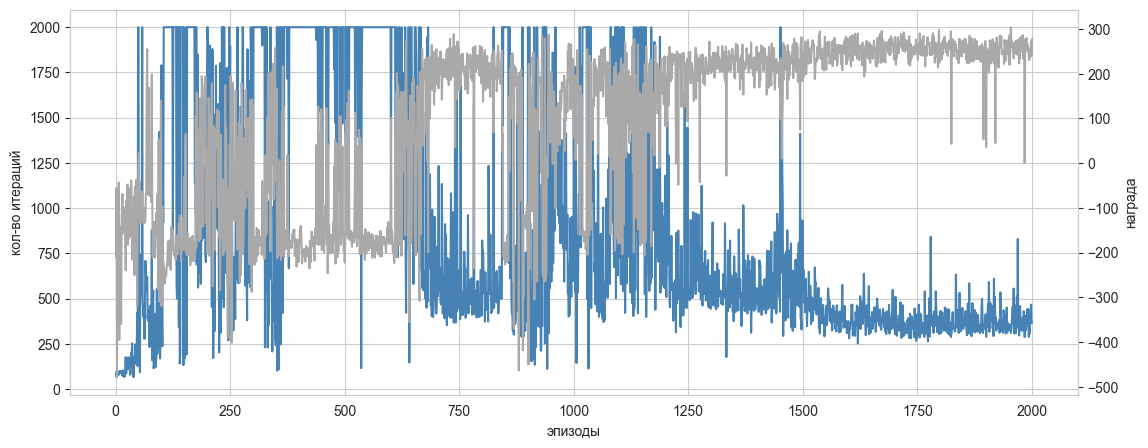

In [24]:
fig, ax = plt.subplots(figsize=(13, 5))

l1, = ax.plot(range(1, len(episode_durations_2) + 1), episode_durations_2, color='steelblue', label='итераций в эпизоде')

ax_r = ax.twinx()
l2, = ax_r.plot(range(1, len(rewards_2) + 1), rewards_2, color='darkgrey', label='награда')

# ax.legend([l1, l2], ['итераций в эпизоде', 'награда'])

ax.set_xlabel('эпизоды')
ax.set_ylabel('кол-во итераций')
ax_r.set_ylabel('награда')

plt.grid(False)
plt.show()
plt.close()

In [ ]:
for i_episode in range(20):
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    # for t in count():
    for t in range(MAX_EPISODE_STEPS):
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        
        # Объединяем done по двум конечным состояниям
        done = terminated or truncated
        
        # присваиваем следующее состояние
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128, optimizer=optimizerAdam)        
        
        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            # отрисовываем график
            plot_durations(episode_durations)
            break

    if i_episode % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')
# отрисовываем финальный график
plot_durations(episode_durations=episode_durations, show_result=True)
plt.ioff()
plt.show()